## Импорт библиотек и константы

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import sparse
from collections import Counter
from random import randint, random
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from rectools import Columns
from rectools.metrics import MAP, Serendipity, calc_metrics
from rectools.model_selection import TimeRangeSplitter

2023-12-20 13:11:44.871717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-20 13:11:44.871750: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Constants
INTERACTIONS_PATH = "./data/interactions.csv"
ITEMS_PATH = "./data/items.csv"
USERS_PATH = "./data/users.csv"
K_RECOMMENDATIONS = 10

## Загрузка данных

In [4]:
interactions_df = pd.read_csv(INTERACTIONS_PATH)
interactions_df = interactions_df.rename(columns={"watched_pct": "weight", "last_watch_dt": "datetime"})
interactions_df['datetime'] = pd.to_datetime(interactions_df['datetime'])
interactions_df.head(5)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [5]:
items_df = pd.read_csv(ITEMS_PATH)
items_df.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [6]:
users_df = pd.read_csv(USERS_PATH)
users_df.head(5)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


## Подготовка данных для модели

### Работа с пропущенными значениями у юзеров

In [7]:
users_df['age'] = users_df['age'].fillna('age_unknown')
users_df['age'] = users_df['age'].astype('category')
users_df['age'].value_counts()

age_25_34      233926
age_35_44      207043
age_45_54      135925
age_18_24      127672
age_55_64       75265
age_65_inf      46271
age_unknown     14095
Name: age, dtype: int64

In [8]:
users_df['income'] = users_df['income'].fillna('income_unknown')
users_df['income'] = users_df['income'].astype('category')
users_df['income'].value_counts()

income_20_40      471519
income_40_60      248330
income_60_90       68674
income_0_20        21836
income_unknown     14776
income_90_150      13985
income_150_inf      1077
Name: income, dtype: int64

In [9]:
users_df['sex'] = users_df['sex'].fillna('sex_unknown')
users_df.loc[users_df.sex == 'М', 'sex'] = 'sex_M'
users_df.loc[users_df.sex == 'Ж', 'sex'] = 'sex_F'
users_df['sex'] = users_df['sex'].astype('category')
users_df['sex'].value_counts()

sex_F          425270
sex_M          401096
sex_unknown     13831
Name: sex, dtype: int64

In [10]:
users_df['kids_flg'] = users_df['kids_flg'].astype('bool')
users_df['kids_flg'] = users_df['kids_flg'].apply(lambda x: f"kids_flg_{x}")
users_df['kids_flg'].value_counts(dropna=False)

kids_flg_False    587209
kids_flg_True     252988
Name: kids_flg, dtype: int64

In [11]:
users_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   user_id   840197 non-null  int64   
 1   age       840197 non-null  category
 2   income    840197 non-null  category
 3   sex       840197 non-null  category
 4   kids_flg  840197 non-null  object  
dtypes: category(3), int64(1), object(1)
memory usage: 15.2+ MB


### Работа с пропущенными значениями у айтемов

In [12]:
# В основном Тренировки от Motify и Лига чемпионов AFC, относящиеся к 2020 году
# Остальная часть относится к 2021 году, но мы потом переведем к категории "2020_inf", поэтому можно и просто 2020 год указать
items_df.loc[items_df['release_year'].isna(), 'release_year'] = 2020.

In [13]:
items_df.loc[items_df['release_year'] < 1920, 'release_year_cat'] = 'inf_1920'
items_df.loc[items_df['release_year'] >= 2020, 'release_year_cat'] = '2020_inf'

for i in range (1920, 2020, 10):
    items_df.loc[(items_df['release_year'] >= i) & (items_df['release_year'] < i+10), 'release_year_cat'] = f'{i}-{i+10}'

items_df = items_df.drop(columns=['release_year'])
items_df['release_year_cat'] = items_df['release_year_cat'].astype('category')

items_df.release_year_cat.value_counts()

2010-2020    8788
2020_inf     2276
2000-2010    2168
1980-1990     745
1990-2000     636
1970-1980     553
1960-1970     342
1950-1960     199
1940-1950     117
1930-1940     104
1920-1930      24
inf_1920       11
Name: release_year_cat, dtype: int64

In [14]:
# Тренировки от Motify 
items_df.loc[items_df.countries.isna(), 'countries'] = 'Россия'
items_df['countries'] = items_df['countries'].str.lower()
items_df['countries'] = items_df['countries'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))
items_df['countries'] = items_df['countries'].astype('category')
items_df['countries'].value_counts().head(10)

россия                 4274
сша                    4090
ссср                   1401
франция                1158
великобритания          718
украина                 340
италия                  256
канада                  233
республика корея        230
великобритания, сша     193
Name: countries, dtype: int64

In [15]:
# Машины-помощники и БиБаБу, которые являются детскими
items_df.loc[items_df.age_rating.isna(), 'age_rating'] = 0
items_df['age_rating'] = items_df['age_rating'].astype('category')
items_df['age_rating'].value_counts()

16.0    5729
12.0    4147
18.0    2547
6.0     1538
0.0     1520
21.0     482
Name: age_rating, dtype: int64

In [16]:
# считаем, что айтемы для детей это айтемы с возрастным ограниченим 0+ и 8+ лет
items_df.loc[items_df['for_kids'].isna(), "for_kids"] = items_df[items_df['for_kids'].isna()]['age_rating'].isin([0, 8])
items_df['for_kids'] = items_df['for_kids'].astype('bool')
items_df['for_kids'].value_counts()

False    14417
True      1546
Name: for_kids, dtype: int64

In [17]:
items_df['genres'] = items_df['genres'].fillna('unknown')
items_df['genres'] = items_df['genres'].str.lower()
items_df['genres'] = items_df['genres'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))
items_df['genres'] = items_df['genres'].astype('category')
items_df['genres'].value_counts().head()

документальное        816
драмы                 719
комедии               564
для взрослых          482
мелодрамы, русские    416
Name: genres, dtype: int64

In [18]:
items_df['studios'] = items_df['studios'].fillna('unknown')
items_df['studios'] = items_df['studios'].str.lower()
items_df['studios'] = items_df['studios'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))
items_df['studios'] = items_df['studios'].astype('category')
items_df['studios'].value_counts().head()

unknown          14898
hbo                353
ленфильм           212
sony pictures      162
paramount           46
Name: studios, dtype: int64

In [19]:
items_df['directors'] = items_df['directors'].fillna('unknown')
items_df['directors'] = items_df['directors'].str.lower()
items_df['directors'] = items_df['directors'].astype('category')
items_df['directors'].value_counts().head()

unknown                1509
оливье шиабоду          511
денис франческо          49
глова роман юрьевич      36
сергей зарев             29
Name: directors, dtype: int64

In [20]:
items_df['actors'] = items_df['actors'].fillna('unknown')
items_df['actors'] = items_df['actors'].str.lower()
items_df['actors'] = items_df['actors'].astype('category')
items_df['actors'].value_counts().head()

unknown                                     2619
александр клюквин                             25
тайлер никсон, маркус лондон, томми ганн      16
жан-пьер морель, оливье шиабоду                8
кэти морган                                    6
Name: actors, dtype: int64

In [21]:
items_df['keywords'] = items_df['keywords'].fillna('unknown')
items_df['keywords'] = items_df['keywords'].str.lower()
items_df['keywords'] = items_df['keywords'].astype('category')
items_df['keywords'].value_counts().head()

unknown                        423
2015, чехия, компания, трех      6
2015, чехия, секс, страсть       6
2011, италия, дом, желаний       5
2006, италия, эвротико           5
Name: keywords, dtype: int64

In [22]:
items_df['description'] = items_df['description'].fillna('-')
items_df['description'] = items_df['description'].str.lower()
items_df['description'].head()

0    мелодрама легендарного педро альмодовара «пого...
1    уморительная современная комедия на популярную...
2    профессиональный рестлер стив остин («все или ...
3    шарлотта рэмплинг, том кортни, джеральдин джей...
4    расчетливая чаровница из советского кинохита «...
Name: description, dtype: object

In [23]:
items_df = items_df.drop(columns=["title_orig"])

In [24]:
items_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   item_id           15963 non-null  int64   
 1   content_type      15963 non-null  object  
 2   title             15963 non-null  object  
 3   genres            15963 non-null  category
 4   countries         15963 non-null  category
 5   for_kids          15963 non-null  bool    
 6   age_rating        15963 non-null  category
 7   studios           15963 non-null  category
 8   directors         15963 non-null  category
 9   actors            15963 non-null  category
 10  description       15963 non-null  object  
 11  keywords          15963 non-null  category
 12  release_year_cat  15963 non-null  category
dtypes: bool(1), category(8), int64(1), object(3)
memory usage: 2.3+ MB


### Работа с пропущенными значениями у интеракций

In [25]:
interactions_df['weight'] = interactions_df['weight'].fillna(0)

In [26]:
interactions_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   user_id    5476251 non-null  int64         
 1   item_id    5476251 non-null  int64         
 2   datetime   5476251 non-null  datetime64[ns]
 3   total_dur  5476251 non-null  int64         
 4   weight     5476251 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


### Подготовка OneHot-фичей для юзеров

In [27]:
user_cat_features = ["age", "income", "sex", "kids_flg"]
users_ohe_df = users_df[["user_id"]].copy()
for feature in user_cat_features:
    ohe_feat_df = pd.get_dummies(users_df[feature])
    users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

In [28]:
users_ohe_df.head()

,user_id,age_18_24,age_25_34,age_35_44,age_45_54,age_55_64,age_65_inf,age_unknown,income_0_20,income_150_inf,income_20_40,income_40_60,income_60_90,income_90_150,income_unknown,sex_F,sex_M,sex_unknown,kids_flg_False,kids_flg_True
0,973171,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,962099,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
2,1047345,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,721985,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,704055,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0


### Подготовка OneHot-фичей для айтемов

Некоторые столбцы могут содержать несколько значений через запятую, например, студии и страны. Для них требуется особенная One-hot-обработка

In [29]:
item_cat_features = ['content_type', 'release_year_cat', 'for_kids', 'age_rating']

items_ohe_df = items_df[["item_id"]].copy()

for feature in item_cat_features:
    ohe_feat_df = pd.get_dummies(items_df[feature], prefix=feature)
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1) 

In [30]:
item_multi_cat_features = ['studios', 'countries', 'genres']

for feature in item_multi_cat_features:
    ohe_feat_df = items_df[feature].str.get_dummies(', ')
    ohe_feat_df.columns = [f"{feature}_{value}" for value in ohe_feat_df.columns]
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1) 

In [31]:
items_ohe_df.head()

,item_id,content_type_film,content_type_series,release_year_cat_1920-1930,release_year_cat_1930-1940,release_year_cat_1940-1950,release_year_cat_1950-1960,release_year_cat_1960-1970,release_year_cat_1970-1980,release_year_cat_1980-1990,...,genres_фильмы,genres_фильмы hbo,genres_фильмы-спектакли,genres_фитнес,genres_футбол,genres_фэнтези,genres_хочу всё знать,genres_шоу,genres_экранизации,genres_юмор
0,10711,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2508,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10716,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7868,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16268,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Создание матрицы взаимодействий

In [32]:
less_5 = len(interactions_df[interactions_df["weight"] < 5])
more_5 = len(interactions_df[interactions_df["weight"] >= 5])
print("Взаимодействия, в которых до 5% досмотра:", less_5)
print("Процент таких взаимодействий во всем датасете:", round(less_5 / (less_5 + more_5) * 100, 2))

Взаимодействия, в которых до 5% досмотра: 1390416
Процент таких взаимодействий во всем датасете: 25.39


Как видно 25% взаимодействий были не очень продолжительными, их можно идентифицировать как негативные примеры для TripletLoss вместо негативного семплирования

In [33]:
interactions_df["user_id"].value_counts()

416206     1341
1010539     764
555233      685
11526       676
409259      625
           ... 
45493         1
615194        1
96848         1
425823        1
697262        1
Name: user_id, Length: 962179, dtype: int64

Также в датасете есть юзеры, которые имеют очень мало взаимодействий, таких нужно отфильтровать

In [34]:
MIN_WATCH_PERCENTAGE = 5
MIN_N_LONG_INTERATCIONS = 5

In [35]:
filtered_interactions_df = interactions_df[interactions_df["weight"] >= MIN_WATCH_PERCENTAGE].copy()

In [36]:
short_interactions_df = interactions_df[interactions_df["weight"] < MIN_WATCH_PERCENTAGE].copy()

In [37]:
valid_users = []
c = Counter(filtered_interactions_df.user_id)
for user_id, entries in c.most_common():
    if entries > MIN_N_LONG_INTERATCIONS:
        valid_users.append(user_id)

In [38]:
valid_items = filtered_interactions_df["item_id"].unique()

In [39]:
items_ohe_df = items_ohe_df[items_ohe_df["item_id"].isin(valid_items)]
users_ohe_df = users_ohe_df[users_ohe_df["user_id"].isin(valid_users)]
valid_users = users_ohe_df["user_id"].values

In [40]:
filtered_interactions_df = filtered_interactions_df[filtered_interactions_df["user_id"].isin(valid_users)]

Отфильтруем короткие интеракции

In [41]:
short_interactions_df = short_interactions_df[short_interactions_df["user_id"].isin(valid_users)]
short_interactions_df = short_interactions_df[short_interactions_df["item_id"].isin(valid_items)]

Получим внутренние индексы для user_id и item_id

In [42]:
user_id_to_internal = {user_id: internal_user_id for (user_id, internal_user_id) in zip(valid_users, range(len(valid_users)))}
item_id_to_internal = {item_id: internal_item_id for (item_id, internal_item_id) in zip(valid_items, range(len(valid_items)))}
internal_to_item_id = {v: k for (k, v) in item_id_to_internal.items()}

In [43]:
filtered_interactions_df["internal_user_id"] = filtered_interactions_df["user_id"].apply(lambda x: user_id_to_internal[x])
filtered_interactions_df["internal_item_id"] = filtered_interactions_df["item_id"].apply(lambda x: item_id_to_internal[x])

In [44]:
short_interactions_df["internal_user_id"] = short_interactions_df["user_id"].apply(lambda x: user_id_to_internal[x])
short_interactions_df["internal_item_id"] = short_interactions_df["item_id"].apply(lambda x: item_id_to_internal[x])

Создадим разреженную матрицу (потому что аллоцировать 20 гигабайт памяти достаточно тяжело 😅)

In [45]:
n_rows = len(valid_users)
n_cols = len(valid_items)

interactions_matrix = sparse.coo_matrix(
    (np.log(filtered_interactions_df["weight"].values + 1), 
     (
         filtered_interactions_df["internal_user_id"].values, 
         filtered_interactions_df["internal_item_id"].values
     )
    ), shape=(n_rows, n_cols)
)
interactions_matrix = interactions_matrix.tocsr()

In [46]:
interactions_matrix

<157374x14143 sparse matrix of type '<class 'numpy.float64'>'
	with 2367249 stored elements in Compressed Sparse Row format>

И проиндексируем датасеты users_ohe_df и items_ohe_df по внутренним айди:

In [47]:
users_ohe_df["internal_user_id"] = users_ohe_df["user_id"].apply(lambda x: user_id_to_internal[x])
users_ohe_df = users_ohe_df.set_index("internal_user_id")

items_ohe_df["internal_item_id"] = items_ohe_df["item_id"].apply(lambda x: item_id_to_internal[x])
items_ohe_df = items_ohe_df.set_index("internal_item_id")

In [48]:
items_ohe_df.head(5)

,item_id,content_type_film,content_type_series,release_year_cat_1920-1930,release_year_cat_1930-1940,release_year_cat_1940-1950,release_year_cat_1950-1960,release_year_cat_1960-1970,release_year_cat_1970-1980,release_year_cat_1980-1990,...,genres_фильмы,genres_фильмы hbo,genres_фильмы-спектакли,genres_фитнес,genres_футбол,genres_фэнтези,genres_хочу всё знать,genres_шоу,genres_экранизации,genres_юмор
internal_item_id,,,,,,,,,,,,,,,,,,,,,
10775,10711,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8154,2508,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3206,10716,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10488,7868,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13907,16268,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
users_ohe_df.head(5)

,user_id,age_18_24,age_25_34,age_35_44,age_45_54,age_55_64,age_65_inf,age_unknown,income_0_20,income_150_inf,income_20_40,income_40_60,income_60_90,income_90_150,income_unknown,sex_F,sex_M,sex_unknown,kids_flg_False,kids_flg_True
internal_user_id,,,,,,,,,,,,,,,,,,,,
0,962099,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
1,721985,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2,846063,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,401219,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
4,155520,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


## DSSM

### Лосс

In [50]:
def triplet_loss(y_true, y_pred, n_dims=256, alpha=0.4):
    anchor = y_pred[:, 0:n_dims]
    positive = y_pred[:, n_dims:n_dims*2]
    negative = y_pred[:, n_dims*2:n_dims*3]

    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)
    
    basic_loss = pos_dist - neg_dist
    loss = K.maximum(basic_loss + alpha, 0.0)
 
    return loss

### Сделать репрезентативное сэмплирование для триплет лосса. (3 балла)

__позитивный атйем - из числа просмотренных, причем большая вероятность у тех, у кого выше процент просмотра__

__негативный айтем - айтем, с которым пользователь взаимодействовал очень короткое время или случайный айтем (не включая просмотренные)__

Вариант, который был предложен на лекции в качестве негативного айтема выдавал случайный (туда даже мог попасть айтем из числа просмотренных)

В генераторе была ошибка с получением фичей, оно осуществлялось через iloc, хотя нужно было использовать loc, так как мы именно в индекс устанавливаем внутренний айдишник айтема

In [51]:
def generator(items, users, interaction_matrix, short_interactions_df, batch_size=1024):
    while True:
        user_id_meta = []
        user_id_interactions = []
        pos = []
        neg = []
        for _ in range(batch_size):
            uid_i = randint(0, interaction_matrix.shape[0] - 1)

            user_interactions = interaction_matrix[uid_i, :].toarray().reshape(-1)
            n_positive_probs = (user_interactions > 0).sum()
            sum_weight = user_interactions.sum()
            positive_probs = np.where(user_interactions > 0, user_interactions / sum_weight, 0)

            short_interacted_items = short_interactions_df[short_interactions_df["internal_user_id"] == uid_i]["internal_item_id"].values
            if short_interacted_items.shape[0] > 0 and random() > 0.9:
                neg_i = np.random.choice(short_interacted_items)
            else:             
                n_negative_probs = interaction_matrix.shape[1] - n_positive_probs
                negative_probs = np.where(user_interactions > 0, 0, 1 / n_negative_probs)
                neg_i = np.random.choice(range(interaction_matrix.shape[1]), p=negative_probs)

            pos_i = np.random.choice(range(interaction_matrix.shape[1]), p=positive_probs)
            user_id_meta.append(users.loc[uid_i])
            user_id_interactions.append(user_interactions)
            
            pos.append(items.loc[pos_i])
            neg.append(items.loc[neg_i])
            
        yield [np.array(user_id_meta), np.array(user_id_interactions), np.array(pos), np.array(neg)], [np.array(user_id_meta), np.array(user_id_interactions)]

### Обучение модели

In [52]:
N_FACTORS = 256
ITEM_MODEL_SHAPE = (items_ohe_df.drop(["item_id"], axis=1).shape[1], ) 
USER_META_MODEL_SHAPE = (users_ohe_df.drop(["user_id"], axis=1).shape[1], )
USER_INTERACTION_MODEL_SHAPE = (interactions_matrix.shape[1], )

In [53]:
print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 256
ITEM_MODEL_SHAPE: (241,)
USER_META_MODEL_SHAPE: (19,)
USER_INTERACTION_MODEL_SHAPE: (14143,)


In [54]:
def item_model(n_factors=N_FACTORS):
    inp = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
    layer_1 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                               kernel_regularizer=keras.regularizers.l2(1e-6),
                               activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp)
    layer_2 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1)
    add = keras.layers.Add()([layer_1, layer_2])
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(add)
    return keras.models.Model(inp, out)


def user_model(n_factors=N_FACTORS):
    inp_meta = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
    inp_interaction = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

    layer_1_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_meta)
    layer_1_interaction = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_interaction)
    layer_2_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1_meta)
    add = keras.layers.Add()([layer_1_meta, layer_2_meta])

    concat_meta_interaction = keras.layers.Concatenate()([add, layer_1_interaction])
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(concat_meta_interaction)
    return keras.models.Model([inp_meta, inp_interaction], out)

# инициализируем модели юзера и айтема
i2v = item_model()
u2v = user_model()


ancor_meta_in = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
ancor_interaction_in = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

pos_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
neg_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)

ancor = u2v([ancor_meta_in, ancor_interaction_in])
pos = i2v(pos_in)
neg = i2v(neg_in)
res = keras.layers.Concatenate(name="concat_ancor_pos_neg")([ancor, pos, neg])

model = keras.models.Model([ancor_meta_in, ancor_interaction_in, pos_in, neg_in], res)

2023-12-20 13:16:27.844370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-20 13:16:27.844410: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-20 13:16:27.844430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (564fd50a9bc2): /proc/driver/nvidia/version does not exist
2023-12-20 13:16:27.845239: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
model_name = 'dssm'
decay = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=1, factor=0.8, verbose=1)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=triplet_loss, optimizer=opt)

In [56]:
model.fit(generator(items=items_ohe_df.drop(["item_id"], axis=1), 
                    users=users_ohe_df.drop(["user_id"], axis=1), 
                    interaction_matrix=interactions_matrix,
                    short_interactions_df=short_interactions_df,
                    batch_size=128), 
          steps_per_epoch=100, 
          epochs=15, 
          initial_epoch=0,
          callbacks=[decay]
)

Epoch 1/15
100/100 [==============================] - 30s 301ms/step - loss: 0.4685 - lr: 0.0010
Epoch 2/15
100/100 [==============================] - 30s 299ms/step - loss: 0.3039 - lr: 0.0010
Epoch 3/15
100/100 [==============================] - 30s 300ms/step - loss: 0.2538 - lr: 0.0010
Epoch 4/15
100/100 [==============================] - ETA: 0s - loss: 0.2646
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
100/100 [==============================] - 30s 299ms/step - loss: 0.2646 - lr: 0.0010
Epoch 5/15
100/100 [==============================] - 30s 301ms/step - loss: 0.2007 - lr: 8.0000e-04
Epoch 6/15
100/100 [==============================] - 30s 299ms/step - loss: 0.1888 - lr: 8.0000e-04
Epoch 7/15
100/100 [==============================] - 30s 298ms/step - loss: 0.1818 - lr: 8.0000e-04
Epoch 8/15
100/100 [==============================] - 30s 300ms/step - loss: 0.1777 - lr: 8.0000e-04
Epoch 9/15
100/100 [==============================] - 30s 301ms/ste

## Autoencoders

### Подготовка данных

In [250]:
BATCH_SIZE = 256

In [251]:
ae_interactions_df = filtered_interactions_df.copy()
ae_interactions_df["weight"] = ae_interactions_df["weight"].apply(lambda x: np.log(x + 1))
ae_interactions_df.head()

,user_id,item_id,datetime,total_dur,weight,internal_user_id,internal_item_id
0,176549,9506,2021-05-11,4250,4.290459,0,0
1,699317,1659,2021-05-29,8317,4.615121,1,1
3,864613,7638,2021-07-05,14483,4.615121,2,2
6,1016458,354,2021-08-14,1672,3.258097,3,3
7,884009,693,2021-08-04,703,2.708050,4,4


In [252]:
interactions_train_df, interactions_test_df = train_test_split(ae_interactions_df,
                                   stratify=ae_interactions_df['user_id'], 
                                   test_size=0.20,
                                   random_state=42)

In [253]:
n_users = ae_interactions_df["internal_user_id"].max() + 1
n_items =  ae_interactions_df["internal_item_id"].max() + 1
n_users, n_items

(143176, 12641)

In [254]:
train_matrix = sparse.coo_matrix(
    (interactions_train_df["weight"].values, 
     (
         interactions_train_df["internal_user_id"].values, 
         interactions_train_df["internal_item_id"].values
     )
    ), shape=(n_users, n_items)
)
train_matrix = train_matrix.tocsr().astype(np.float32)
train_matrix

<143176x12641 sparse matrix of type '<class 'numpy.float32'>'
	with 1678303 stored elements in Compressed Sparse Row format>

In [255]:
test_matrix = sparse.coo_matrix(
    (interactions_test_df["weight"].values, 
     (
         interactions_test_df["internal_user_id"].values, 
         interactions_test_df["internal_item_id"].values
     )
    ), shape=(n_users, n_items)
)
test_matrix = test_matrix.tocsr().astype(np.float32)
test_matrix

<143176x12641 sparse matrix of type '<class 'numpy.float32'>'
	with 419576 stored elements in Compressed Sparse Row format>

In [256]:
class UserOrientedDataset(Dataset):
    def __init__(self, X):
        super().__init__()
        self.X = X
        self.n = X.shape[0]

    def __len__(self):
        return self.n

    def __getitem__(self, index):
        return torch.from_numpy(self.X[index, :].toarray().reshape(-1))

In [257]:
train_dl = DataLoader(
    UserOrientedDataset(train_matrix),
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dl = DataLoader(
    UserOrientedDataset(test_matrix),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
)

In [258]:
dls = {'train': train_dl, 'test': test_dl}

### Модель и доработка её архитектуры (2 балла)

In [287]:
SEED = 0
LR = 1e-3
WEIGHT_DECAY = 0.01
GAMMA = 0.9995

In [288]:
'Входных нейронов', n_items

('Входных нейронов', 12641)

In [361]:
class AutoEncoder(nn.Module):
    def __init__(self, in_and_out_features):
        super().__init__()
        self.in_and_out_features = in_and_out_features
        self.hidden_size = 500

        self.sequential = nn.Sequential(
            nn.Linear(in_and_out_features, self.hidden_size, bias=True),
            nn.ReLU(),
            nn.Linear(self.hidden_size, in_and_out_features, bias=True)
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

In [362]:
torch.manual_seed(SEED)

In [363]:
autoencoder = AutoEncoder(n_items)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [364]:
autoencoder

AutoEncoder(
  (sequential): Sequential(
    (0): Linear(in_features=12641, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=12641, bias=True)
  )
)

### Обучение

In [365]:
NUM_EPOCHS = 15

In [366]:
def rmse_for_sparse(x_pred, x_true):
    mask = (x_true > 0)
    sq_diff = (x_pred * mask - x_true) ** 2
    mse = sq_diff.sum() / mask.sum()
    return mse ** (1/2)

In [367]:
metrics_dict = {
    "Epoch": [],
    "Train RMSE": [],
    "Test RMSE": [],
}

In [368]:
for epoch in tqdm(range(NUM_EPOCHS)):
    metrics_dict["Epoch"].append(epoch)
    for stage in ['train', 'test']:
        with torch.set_grad_enabled(stage == 'train'):
            if stage == 'train':
                autoencoder.train()
            else:
                autoencoder.eval()

            loss_at_stage = 0 
            for batch in dls[stage]:
                x_pred = autoencoder(batch)
                loss = rmse_for_sparse(x_pred, batch)
                if stage == "train":
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()
                loss_at_stage += loss.item() * len(batch)
            rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
            metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)

  0%|          | 0/15 [00:00<?, ?it/s]

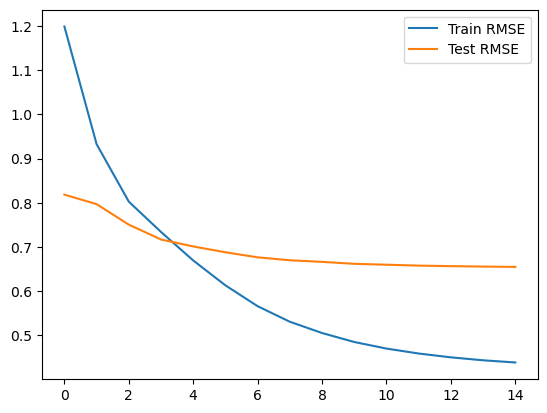

In [369]:
pd.DataFrame(metrics_dict)[["Train RMSE", "Test RMSE"]].plot()
plt.show()

Возможно стоило и дальше обучать, но разрыв бы продолжал увеличиваться. При других архитектурах (добавление уровней) обучается значительно дольше и ошибка выше

### Оценка качества автоэнкодера

In [370]:
internal_user_id = 1000

In [371]:
def get_recommendation(model, matrix, internal_user_id, k):
    reals = matrix[internal_user_id, :].toarray()
    with torch.no_grad():
        predictions = model(torch.Tensor(reals))
    predicted_items = np.argpartition(predictions.numpy().reshape(-1), -k)[-k:][::-1]
    return predicted_items[:k]

In [372]:
get_recommendation(autoencoder, test_matrix, internal_user_id, 10) 

array([ 9528, 10381,  9029, 11566,  5322,  5656, 11059,  9563,  7111,
        7182])

Для оценки будем использовать пользователей, у которых больше 10 айтемов в числе просмотренных

In [373]:
test_users_items_count = interactions_test_df.groupby(["user_id"])["item_id"].agg("count")
users_more_10_items = test_users_items_count[test_users_items_count >= 10]
users_more_10_items

user_id
576        19
840        10
858        18
1456       11
1823       16
           ..
1097444    33
1097459    10
1097470    10
1097508    19
1097513    12
Name: item_id, Length: 4529, dtype: int64

In [374]:
reco_data = []

for user_id in tqdm(users_more_10_items.index):
    internal_user_id = user_id_to_internal[user_id]
    internal_items = get_recommendation(autoencoder, train_matrix, internal_user_id, 10)
    items = [internal_to_item_id[internal_item_id] for internal_item_id in internal_items]
    for (ind, item_id) in enumerate(items):
        reco_data.append(dict(item_id=item_id, user_id=user_id, rank=ind+1))

  0%|          | 0/4529 [00:00<?, ?it/s]

In [375]:
reco_df = pd.DataFrame(reco_data)

In [376]:
calc_metrics(
    {'map@10': MAP(k=10), 'serendipity': Serendipity(k=10)},
    reco=reco_df,
    interactions=interactions_test_df[interactions_test_df["user_id"].isin(users_more_10_items.index)],
    prev_interactions=interactions_train_df[interactions_train_df["user_id"].isin(users_more_10_items.index)],
    catalog=interactions_train_df[interactions_train_df["user_id"].isin(users_more_10_items.index)][Columns.Item].unique()
)

{'map@10': 1.678540479405457e-05, 'serendipity': 6.119929068345077e-06}

### Подготовка модели для сервиса

In [377]:
full_matrix = sparse.coo_matrix(
    (ae_interactions_df["weight"].values, 
     (
         ae_interactions_df["internal_user_id"].values, 
         ae_interactions_df["internal_item_id"].values
     )
    ), shape=(n_users, n_items)
)
full_matrix = full_matrix.tocsr().astype(np.float32)
full_matrix

<143176x12641 sparse matrix of type '<class 'numpy.float32'>'
	with 2097879 stored elements in Compressed Sparse Row format>

In [378]:
full_dl = DataLoader(
    UserOrientedDataset(full_matrix),
    batch_size = BATCH_SIZE,
    shuffle = True
)

In [379]:
autoencoder = AutoEncoder(n_items)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [380]:
autoencoder.train()
for epoch in tqdm(range(NUM_EPOCHS)):
    for batch in full_dl:
        x_pred = autoencoder(batch)
        loss = rmse_for_sparse(x_pred, batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

  0%|          | 0/15 [00:00<?, ?it/s]

In [381]:
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

In [385]:
autoencoder_loaded = Model(n_items)
autoencoder_loaded.load_state_dict(torch.load('autoencoder.pth'))
autoencoder_loaded.eval()

Model(
  (sequential): Sequential(
    (0): Linear(in_features=12641, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=12641, bias=True)
  )
)

In [386]:
get_recommendation(autoencoder_loaded, test_matrix, internal_user_id, 10) 

array([10201,   322, 12208, 11059,  7494,   885,  7949,  7944,  8188,
       10628])

In [387]:
with open('autoencoder_item_inv_mappings.json', 'w', encoding="utf-8") as f:
    json.dump({int(k): int(v) for (k, v) in internal_to_item_id.items()}, f)

In [388]:
with open('autoencoder_user_mappings.json', 'w', encoding="utf-8") as f:
    json.dump({int(k): int(v) for (k, v) in user_id_to_internal.items()}, f)

In [389]:
sparse.save_npz("autoencoder_user_item_matrix.npz", full_matrix)

## Frameworks (Recbole)

In [407]:
import logging
from recbole.config import Config
from recbole.utils.case_study import full_sort_topk
from recbole.quick_start import load_data_and_model
from recbole.data import create_dataset, data_preparation, Interaction
from recbole.model.sequential_recommender import BERT4Rec
from recbole.model.general_recommender import RecVAE
from recbole.trainer import Trainer
from recbole.utils import init_seed
from recbole.quick_start import run_recbole

In [325]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

### Подготовка и сохранение данных для Recbole

In [326]:
recbole_df = interactions_df[["user_id", "item_id", "datetime"]].copy()
recbole_df["datetime"] = recbole_df["datetime"].values.astype(np.int64) // 10 ** 9
recbole_df = recbole_df.rename(columns={'user_id': 'user_id:token', 'item_id': 'item_id:token', 'datetime': 'timestamp:float'})

In [327]:
!mkdir recbox_data

mkdir: cannot create directory ‘recbox_data’: File exists


In [328]:
recbole_df.to_csv('recbox_data/recbox_data.inter', index=False, sep='\t')

### Конфиг для Recbole

In [338]:
parameter_dict = {
    'data_path': '',
    'USER_ID_FIELD': 'user_id',
    'ITEM_ID_FIELD': 'item_id',
    'TIME_FIELD': 'timestamp',
    'device': 'CPU',
    'user_inter_num_interval': "[40,inf)",
    'item_inter_num_interval': "[40,inf)",
    'load_col': {'inter': ['user_id', 'item_id', 'timestamp']},
    'neg_sampling': None,
    'train_neg_sample_args': None,
    'epochs': 10,
    'eval_args': {
        'split': {'RS': [9, 0, 1]},
        'group_by': 'user',
        'order': 'TO',
        'mode': 'full'
    },
    'metrics': ['MAP', 'ItemCoverage', 'AveragePopularity']
}

### Эксперименты с разными моделями (2 балла)

In [332]:
model_list = ['Pop', 'MultiDAE', 'MacridVAE', "RecVAE"] 

model_results = []
for model_name in model_list:
    result = run_recbole(model=model_name, dataset="recbox_data", config_dict = parameter_dict)
    model_results.append({**result, 'model_name': model_name})

19 Dec 08:52    INFO  ['/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/jovyan/.local/share/jupyter/runtime/kernel-1c288f33-ef01-4fa5-a243-e411b426aea2.json']
19 Dec 08:52    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = recbox_data
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 10
train_batch_size = 2048
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [9, 0, 1]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = False
metrics = [

In [333]:
model_results

[{'best_valid_score': -inf,
  'valid_score_bigger': True,
  'best_valid_result': None,
  'test_result': OrderedDict([('map@10', 0.0189),
               ('itemcoverage@10', 0.0112),
               ('averagepopularity@10', 3254.4746)]),
  'model_name': 'Pop'},
 {'best_valid_score': -inf,
  'valid_score_bigger': True,
  'best_valid_result': None,
  'test_result': OrderedDict([('map@10', 0.0407),
               ('itemcoverage@10', 0.1582),
               ('averagepopularity@10', 2510.1628)]),
  'model_name': 'MultiDAE'},
 {'best_valid_score': -inf,
  'valid_score_bigger': True,
  'best_valid_result': None,
  'test_result': OrderedDict([('map@10', 0.0385),
               ('itemcoverage@10', 0.4104),
               ('averagepopularity@10', 2273.6575)]),
  'model_name': 'MacridVAE'},
 {'best_valid_score': -inf,
  'valid_score_bigger': True,
  'best_valid_result': None,
  'test_result': OrderedDict([('map@10', 0.0415),
               ('itemcoverage@10', 0.1427),
               ('averagepopular

Лучшее значение MAP@10 достигается у RecVAE

### Обучение и тестирование потенциально хорошей модели BERT4Rec

In [348]:
config = Config(model='BERT4Rec', dataset='recbox_data', config_dict=parameter_dict)
init_seed(config['seed'], config['reproducibility'])

In [349]:
dataset = create_dataset(config)
train_data, valid_data, test_data = data_preparation(config, dataset)

19 Dec 09:26    INFO  [Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
19 Dec 09:26    INFO  [Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [9, 0, 1]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}]


In [350]:
model = BERT4Rec(config, train_data.dataset)

In [352]:
model

BERT4Rec(
  (item_embedding): Embedding(3295, 64, padding_idx=0)
  (position_embedding): Embedding(50, 64)
  (trm_encoder): TransformerEncoder(
    (layer): ModuleList(
      (0-1): 2 x TransformerLayer(
        (multi_head_attention): MultiHeadAttention(
          (query): Linear(in_features=64, out_features=64, bias=True)
          (key): Linear(in_features=64, out_features=64, bias=True)
          (value): Linear(in_features=64, out_features=64, bias=True)
          (softmax): Softmax(dim=-1)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (dense): Linear(in_features=64, out_features=64, bias=True)
          (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
          (out_dropout): Dropout(p=0.2, inplace=False)
        )
        (feed_forward): FeedForward(
          (dense_1): Linear(in_features=64, out_features=256, bias=True)
          (dense_2): Linear(in_features=256, out_features=64, bias=True)
          (LayerNorm): LayerNorm((64,), eps=1e-12

In [351]:
trainer = Trainer(config, model)
best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)

19 Dec 09:41    INFO  epoch 0 training [time: 877.63s, train loss: 2757.1272]
19 Dec 09:41    INFO  Saving current: saved/BERT4Rec-Dec-19-2023_09-26-42.pth
19 Dec 09:56    INFO  epoch 1 training [time: 906.15s, train loss: 2592.0990]
19 Dec 09:56    INFO  Saving current: saved/BERT4Rec-Dec-19-2023_09-26-42.pth
19 Dec 10:09    INFO  epoch 2 training [time: 808.08s, train loss: 2534.2304]
19 Dec 10:09    INFO  Saving current: saved/BERT4Rec-Dec-19-2023_09-26-42.pth
19 Dec 10:23    INFO  epoch 3 training [time: 791.07s, train loss: 2508.9247]
19 Dec 10:23    INFO  Saving current: saved/BERT4Rec-Dec-19-2023_09-26-42.pth
19 Dec 10:36    INFO  epoch 4 training [time: 788.79s, train loss: 2490.9033]
19 Dec 10:36    INFO  Saving current: saved/BERT4Rec-Dec-19-2023_09-26-42.pth
19 Dec 10:49    INFO  epoch 5 training [time: 792.64s, train loss: 2476.8456]
19 Dec 10:49    INFO  Saving current: saved/BERT4Rec-Dec-19-2023_09-26-42.pth
19 Dec 11:02    INFO  epoch 6 training [time: 806.36s, train los

In [354]:
test_result = trainer.evaluate(test_data)

19 Dec 14:03    INFO  Loading model structure and parameters from saved/BERT4Rec-Dec-19-2023_09-26-42.pth


In [355]:
test_result

OrderedDict([('map@10', 0.035),
             ('itemcoverage@10', 0.5935),
             ('averagepopularity@10', 1347.109)])

Результат не такой хороший как ожидалось. Возможно стоило дольше обучать. Но для сервиса будем использовать RecVAE